In [1]:
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
import pathlib
import pymysql
import getpass
import pickle
from zipfile import ZipFile
import string
import re
from collections import Counter
import logging
import warnings
from wordcloud import WordCloud

import pylab
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score as AUC

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec

from bs4 import BeautifulSoup

%matplotlib inline

C:\Users\rsouza\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


If this was the case of accessing the MySQL:

Accessing a dump of the database:

In [2]:
df = pd.read_csv('frage.csv', encoding='latin_1', sep='%', header=None, names=['originalfrage','kurlfrage'])
df.head(10)

,originalfrage,kurlfrage
0,"Kopf: Kopf, Haupt; auch scherzh./übertr.","Kopf, Haupt; auch scherzh./übertr."
1,Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...,Kopf/Haupt (urspr.Bed.) in Vergl./Ra.*
2,Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...,Kopf/Haupt (übertr.) in Vergl./Ra.*
3,"Kopf: schöner, ebenmäßig gebauter Kopf (Christ...","schöner, ebenmäßiger Kopf (Christus-, Titusk.)"
4,"Kopf: häßlicher, unebenmäßiger Kopf","häßlicher, unebenmäßiger Kopf"
5,Kopf: großer Kopf; großkopfig,großer Kopf; großkopfig
6,Kopf: Wasserkopf,Wasserkopf
7,Kopf: kleiner Kopf,kleiner Kopf
8,Kopf: oben zugespitzter Kopf,oben zugespitzter Kopf
9,Kopf: langer Kopf,langer Kopf


In [3]:
df.originalfrage[0:20]

0              Kopf: Kopf, Haupt; auch scherzh./übertr.
1     Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...
2     Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...
3     Kopf: schöner, ebenmäßig gebauter Kopf (Christ...
4                   Kopf: häßlicher, unebenmäßiger Kopf
5                         Kopf: großer Kopf; großkopfig
6                                      Kopf: Wasserkopf
7                                    Kopf: kleiner Kopf
8                          Kopf: oben zugespitzter Kopf
9                                     Kopf: langer Kopf
10                           Kopf: kurzer, platter Kopf
11                                    Kopf: runder Kopf
12                                   Kopf: breiter Kopf
13                                  Kopf: schmaler Kopf
14                                  Kopf: schiefer Kopf
15    Kopf: Kopf mit dunkler Gesichtsfarbe und kraus...
16    Kopf: mißgestalteter Kopf (Fischkopf "Kindskop...
17    Kopf: Kopf mit Ungeziefer behaftet (Laus-,

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24309 entries, 0 to 24308
Data columns (total 2 columns):
originalfrage    24309 non-null object
kurlfrage        17413 non-null object
dtypes: object(2)
memory usage: 379.9+ KB


In [5]:
class Text_Cleaning_Utilities(object):
    """Tools for processing text into segments for further learning"""

    @staticmethod
    def text_to_wordlist(text, 
                         remove_stopwords=False, 
                         remove_html=False, 
                         remove_non_letters=False, 
                         steeming=False):
        '''Split a text into a list of words'''
        #text = text.replace('-\n','')
        text = text.lower()
        if remove_html:
            text = BeautifulSoup(text, "html5lib").get_text()
        if remove_non_letters:
            text = re.sub("[^-A-Za-z0-9_]", " ", text)
        list_words = word_tokenize(text)
        list_words = [w.strip(string.punctuation) for w in list_words if w not in string.punctuation]
        list_words = [w for w in list_words if len(w) > 1]
        if remove_stopwords:
            stops = set(stopwords.words("german"))
            list_words = [w for w in list_words if w not in stops]
        if steeming:
            stemmer = PorterStemmer()
            list_words = [stemmer.stem(item) for item in list_words]
        return list_words
    
    @staticmethod
    def df_to_list_of_texts(dataframe, column, 
                            remove_stopwords=False, 
                            remove_html=False, 
                            remove_non_letters=False, 
                            steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(' '.join(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                                 remove_stopwords=remove_stopwords,
                                                                                 remove_html=remove_html,
                                                                                 remove_non_letters=remove_non_letters,
                                                                                 steeming=steeming)))
            
        return clean_texts

    @staticmethod
    def df_to_list_of_tokens(dataframe, column, 
                             remove_stopwords=False, 
                             remove_html=False, 
                             remove_non_letters=False, 
                             steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.extend(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                        remove_stopwords=remove_stopwords,
                                                                        remove_html=remove_html,
                                                                        remove_non_letters=remove_non_letters,
                                                                        steeming=steeming))
            
        return clean_texts
    
   

In [6]:
all_questionaries = Text_Cleaning_Utilities.df_to_list_of_tokens(df, 
                                                                 'originalfrage', 
                                                                 remove_stopwords=False,
                                                                 remove_html=False,)

In [7]:
cleaned = Text_Cleaning_Utilities.df_to_list_of_tokens(df,
                                                       'originalfrage',
                                                       remove_stopwords=True,
                                                       remove_html=False,)

In [8]:
all_questionaries[0:30]

['kopf',
 'kopf',
 'haupt',
 'auch',
 'scherzh./übertr',
 'kopf',
 'kopf/haupt',
 'in',
 'urspr',
 'bed',
 'in',
 'vergl./ra',
 'kopf',
 'stehn',
 'der',
 'kopf',
 'möchte',
 'einem',
 'zerspringen',
 'kopf',
 'kopf/haupt',
 'übertr',
 'in',
 'vergl./ra',
 'das',
 'ist',
 'ein',
 'feiner/offener',
 'kopf',
 'jem']

In [9]:
freqdist = Counter(all_questionaries)
freqdist.most_common(30)

[('die', 3567),
 ('wie', 3563),
 ('der', 3538),
 ('das', 2275),
 ('komp', 1673),
 ('in', 1520),
 ('ra', 1411),
 ('man', 1408),
 ('mit', 1251),
 ('den', 1247),
 ('und', 1126),
 ('auf', 1093),
 ('bed', 1078),
 ('z.b', 1067),
 ('dem', 1057),
 ('ist', 1038),
 ('ein', 981),
 ('des', 931),
 ('von', 829),
 ('es', 807),
 ('für', 802),
 ('im', 750),
 ('wird', 745),
 ('sich', 719),
 ('zu', 707),
 ('auch', 704),
 ('an', 704),
 ('aus', 645),
 ('u.a', 637),
 ('gewerbe', 615)]

In [10]:
freqdist_c = Counter(cleaned)
freqdist_c.most_common(30)
#export to spreadsheet

[('komp', 1673),
 ('ra', 1411),
 ('bed', 1078),
 ('z.b', 1067),
 ('u.a', 637),
 ('gewerbe', 615),
 ('pl', 569),
 ('sg./pl', 496),
 ('ausdrücke', 422),
 ('usw', 374),
 ('nennt', 373),
 ('beim', 367),
 ('bez', 307),
 ('kopf', 292),
 ('heißt', 289),
 ('tut', 281),
 ('bes', 264),
 ('od', 263),
 ('holz', 253),
 ('gehen', 234),
 ('u.ä', 230),
 ('womit', 229),
 ('schneiderei', 212),
 ('auge', 210),
 ('syn', 209),
 ('ab', 207),
 ('gibt', 201),
 ('vb', 201),
 ('hand', 200),
 ('feld', 200)]

In [11]:
texts = ' '.join(all_questionaries)
wordcloud = WordCloud().generate(texts)

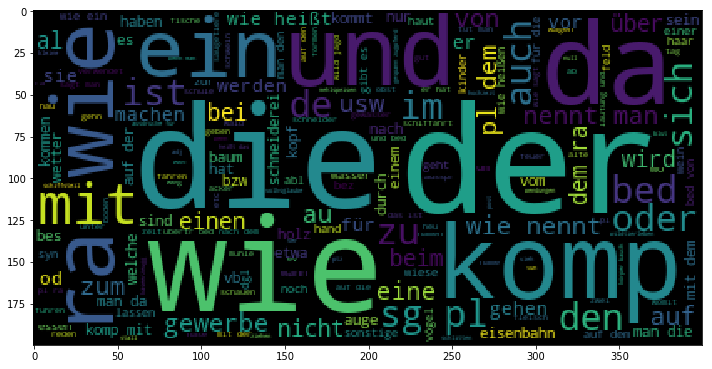

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

In [13]:
cleaned_texts = ' '.join(cleaned)
wordcloud = WordCloud().generate(cleaned_texts)

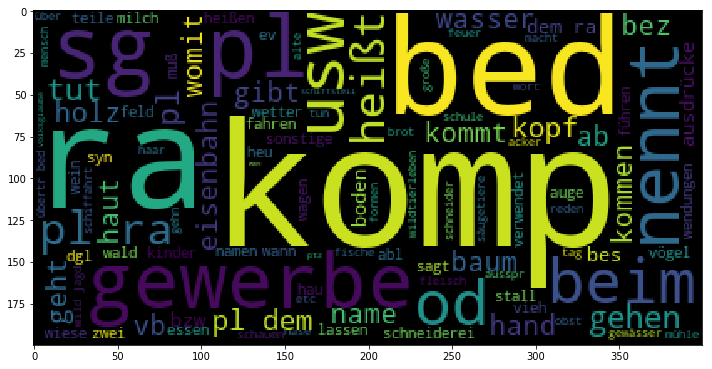

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

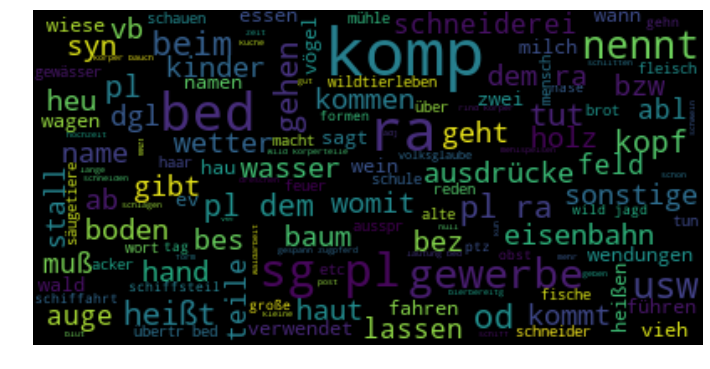

In [15]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(cleaned_texts)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Understanding contexts in which words occur:

In [16]:
expression = 'komp'
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_texts)
nltk_text = nltk.Text(tokens)
nltk_text.concordance(expression.lower(), width=120, lines=10)

Displaying 10 of 1721 matches:
schädeln schlag kopf kopf enthaupten köpfen kopf sonstige komp kopf / schädel gw weiberkopf kopf sonstige komp kopf / sc
 sonstige komp kopf / schädel gw weiberkopf kopf sonstige komp kopf / schädel bw kopfstück totenkopf totenkopf totenkopf
te hirnschale /- kästlein kopf / hirn hirn bed stirn kopf komp hirn hirnrissig usw kopf hinterhaupt kopf schläfe kopf hö
chlag mund krankheiten übelriechender mund mundfäule mund komp mund mund mundvoll palmso palmsonntag palmtag blumentag b
 sonntag freudensonntag mettag kleine ostersonntag ostern komp ostern z . b osterwachs aberglaube dabei licht stock kerz
üchel maultüchel farbe stoff arten knüpfung kopf sonstige komp zahn gw kopf sonstige komp zahn bw kopf / zahn aberglaube
f arten knüpfung kopf sonstige komp zahn gw kopf sonstige komp zahn bw kopf / zahn aberglaube soweit schon erwähnt kopf 
leisches kopf / kiefer beißen eig ./ übertr bed wendungen komp kopf / kiefer mummeln kopf gaumen kopf wunder gaumen abge
f

Words that occur in similar contexts than the query expression:

In [17]:
nltk_text.similar(expression)

abl ra syn wendungen ausdrücke teile arten körper kleine bed adj große
zeit verbindungen wild leben angeheiratet aberglaube usw vergleiche


Collocations are expressions of multiple words which commonly co-occur.

In [18]:
nltk_text.collocations(num=100, window_size=2)

hautschwellg ./-; ./- geschwür; stoß bewegg; übertr bed; lautung bed;
inf ptz; besondere ausdrücke; umschreibungen subst; zunfttag
zunftheiliger; übl umschreibungen; zweiter stelle; sachl fix;
transport heiratsgutes; besonderen namen; wort vermeiden; erster
stelle; bes ausdrücke; bräuche zunfttag; eigensch brot; genaue ausspr;
subst ausdrücke; versch arten; ersatzw wendg; füg ersatzw;
zunftheiliger gewerbe; gewerbe tätigk; pers präs; ergebnis davon; wein
wein; käseerzeugg käse; charaktereigensch bart; fuhrwerk wagen; uhr
herum; sachl lex; komp ausdrücken; etwaige komp; ind präs; haar haar;
buttererzeugg butter; adj auge; mensch charaktereigensch; mittel
dagegen; lock scheuchrufe; wiese wiese; formen verwendungen; guter
schlechter; bed übl; sagen kinder; geburt sternbild; volksbräuche
bauernregeln; männliche zuchttier; sonstige ausdrücke; frage
gestrichen; offenen herd; wachstum reife; bauer bauer; sprüche
brotsorten; formen verwendg; altdt bez; schwieriger ausführg; gewerbe
komp; allg 

Just Bigrams (by frequency)

In [21]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)

for a, b in (finder2.above_score(bigram_measures.raw_freq, 10.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

pl ra
dem ra
übertr bed
lautung bed
komp z
./- geschwür
hautschwellg ./-
stoß bewegg
-/ hanfarbeit
flachs -/
gewerbe komp
ra z
-/ maurerarbeit
bau -/
besondere ausdrücke
bes ausdrücke
ev diff
bed z
inf ptz
ausdrücke ra
ra brot
/- strauch
komp syn
waldbaum /-
subst ausdrücke
bed übl
eigensch brot
umschreibungen subst
übl umschreibungen
etwaige komp
bw z
stelle z
besonderen namen
sonstige komp
sachl fix
wort vermeiden
zweiter stelle
adj auge
komp ausdrücken
genaue ausspr
sonstige ausdrücke
wein wein
bed ra
erster stelle
gewerbe tätigk
pl genus
ra bräuche
sg pl
versch arten
geschl pl
gw z
schneiderei komp
a feld
füg ersatzw
haar haar
komp adj
wiese wiese
abl z
bes namen
bräuche zunfttag
ra gewerbe
zunftheiliger gewerbe
transport heiratsgutes
wendungen ra
zunfttag zunftheiliger
auge ra
bed feld
bed hautkrankh
gewässer komp
holz waldbaum
pl bed
pl dim
bed komp
haut komp
usw gewerbe
-/ entwässerg
.+ ptz
a hautkrankh
bauer bauer
be -/
bed schneiderei
käseerzeugg käse
schauen ra
a bed
a schnei

Same, but using Pointwise Mutual Information (relevant are not necessarily the most frequent).

In [22]:
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

zunfttag zunftheiliger
männliche zuchttier
konj ii
transport heiratsgutes
offenen herd
guter schlechter
ersatzw wendg
ergebnis davon
ind präs
hautschwellg ./-
volksbräuche bauernregeln
mittel dagegen
./- geschwür
pers präs
woraus bestehend
geburt sternbild
sachl lex
sprüche brotsorten
bräuche zunfttag
/- strauch
charaktereigensch bart
stoß bewegg
umschreibungen subst
buttererzeugg butter
mensch charaktereigensch
junge welt
inf ind
zweiter stelle
sachl fix
inf .+


Trigrams (raw frequency)

In [23]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
#finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.above_score(trigram_measures.raw_freq,10.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

hautschwellg ./- geschwür
flachs -/ hanfarbeit
bau -/ maurerarbeit
waldbaum /- strauch
bed übl umschreibungen
subst ausdrücke ra
umschreibungen subst ausdrücke
übl umschreibungen subst
ausdrücke ra brot
übertr bed z
bräuche zunfttag zunftheiliger
zunfttag zunftheiliger gewerbe
ra bräuche zunfttag
be -/ entwässerg
ersatzw wendg ra
alm -/ weidewirtsch
füg ersatzw wendg
inf .+ ptz
komp stoß bewegg
jagd besondere ausdrücke
erster stelle z
./- geschwür komp
mensch charaktereigensch bart
wendg ra z
bed eigensch ra
zweiter stelle z
altdt bez monat
bart mensch charaktereigensch
bedeutet geburt sternbild
ersatzw wendungen ra
kinder bedeutet geburt
ra gewerbe komp


Trigrams (PMI)

In [24]:
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

danher einher fürher
schlechter schwieriger ausführg
rufn on lostage
ausher danher einher
aufhin aushin danhin
guter schlechter schwieriger
zucht unfähig gemacht
sp .- belege
wachstum reife ernte
ketten kessel sensen
abhin aufhin aushin
holzstücke bau pergel
mindestumfang angeben anwesen
rebengerüst holzstücke bau
bräuche zunfttag zunftheiliger
bezügl guter schlechter
ruf -/ heiligenn
hautschwellg ./- geschwür
bedeutet geburt sternbild
koll .- bezeichnung
nagel ketten kessel
ind präs ppt
zugpferd zurufe pferde
junge welt bringen
inf ind präs
füg ersatzw wendg
altdt bez monat
mdal ausspr altdt
ausdrücke wachstum reife
zunfttag zunftheiliger gewerbe


n-grams

In [25]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
xgrams_counter.most_common(30)

[(('pl', './', 'dem', 'ra'), 147),
 (('komp', 'z', '.', 'b'), 63),
 (('ra', 'z', '.', 'b'), 54),
 (('bed', 'z', '.', 'b'), 42),
 (('brot', '/', 'eigensch', 'brot'), 32),
 (('bed', 'übl', 'umschreibungen', 'subst'), 32),
 (('übl', 'umschreibungen', 'subst', 'ausdrücke'), 32),
 (('umschreibungen', 'subst', 'ausdrücke', 'ra'), 32),
 (('ra', 'brot', '/', 'eigensch'), 32),
 (('subst', 'ausdrücke', 'ra', 'brot'), 31),
 (('ausdrücke', 'ra', 'brot', '/'), 31),
 (('bw', 'z', '.', 'b'), 30),
 (('stelle', 'z', '.', 'b'), 30),
 (('ra', './', 'adj', 'auge'), 27),
 (('hin', '-', 'und', '-'), 25),
 (('gw', 'z', '.', 'b'), 24),
 (('sg', './', 'pl', 'genus'), 24),
 (('übertr', 'bed', 'z', '.'), 23),
 (('u', '.', 'a', 'feld'), 23),
 (('-', 'und', '-', 'herbewegen'), 23),
 (('komp', 'adj', '.', 'füg'), 22),
 (('adj', '.', 'füg', 'ersatzw'), 22),
 (('abl', 'z', '.', 'b'), 22),
 (('bräuche', 'zunfttag', 'zunftheiliger', 'gewerbe'), 21),
 (('ra', 'bräuche', 'zunfttag', 'zunftheiliger'), 19),
 (('auge', 'ra'

In [26]:
freqdist_c.most_common(10)

[('komp', 1673),
 ('ra', 1411),
 ('bed', 1078),
 ('z.b', 1067),
 ('u.a', 637),
 ('gewerbe', 615),
 ('pl', 569),
 ('sg./pl', 496),
 ('ausdrücke', 422),
 ('usw', 374)]

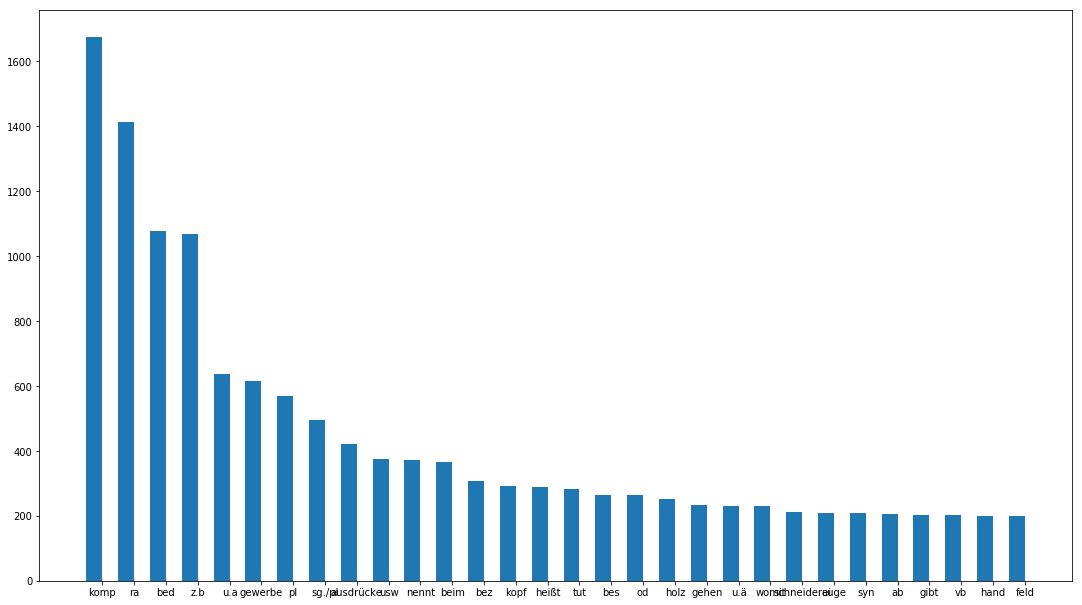

In [27]:
labels, values = zip(*freqdist_c.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

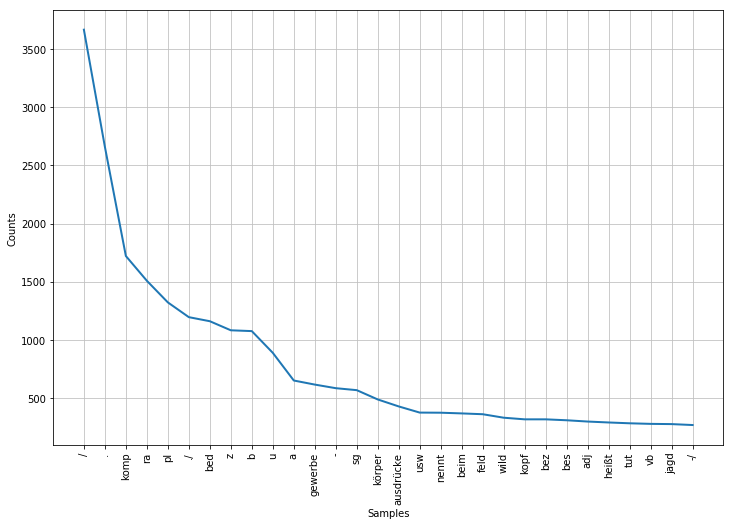

In [28]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

In [29]:
from textblob import TextBlob
from textblob import Word

In [30]:
blob = TextBlob(texts)

In [31]:
blob.tags[0:20]

[('kopf', 'NN'),
 ('kopf', 'NN'),
 ('haupt', 'NN'),
 ('auch', 'JJ'),
 ('scherzh./übertr', 'NN'),
 ('kopf', 'NN'),
 ('kopf/haupt', 'NN'),
 ('in', 'IN'),
 ('urspr', 'JJ'),
 ('bed', 'NN'),
 ('in', 'IN'),
 ('vergl./ra', 'NN'),
 ('kopf', 'NN'),
 ('stehn', 'NN'),
 ('der', 'NN'),
 ('kopf', 'NN'),
 ('möchte', 'NN'),
 ('einem', 'NN'),
 ('zerspringen', 'NN'),
 ('kopf', 'NN')]

In [34]:
import spacy
de_nlp = spacy.load('de_core_news_sm')  #https://spacy.io/models/de

In [35]:
de_doc = de_nlp(texts)

ValueError: [E088] Text of length 1334402 exceeds maximum of 1000000. The v2.x parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.